# **Lesson 01**

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.stats import norm, cauchy, chi2

In [58]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params

# Exercise 01.1

**Test the Pseudo-Random Number generator downloaded from the NSL Ariel web site**

1. $\langle r \rangle = \int_0^1 r dr = 1/2$. Make a picture of the estimation of $\langle r \rangle$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle r \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$(see below: Computing statistical uncertainties).

2. $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$. Make a picture of the estimation of $\sigma^2$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle (r-1/2)^2 \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).

3. Divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. Obviously, the number of expected events observed in each sub-interval after $n$ *throws*, according to a uniform distribution, is $np = n\times 1/M= n/M$. Fix $M=10^2$ and use for $n$ the first $10^4$ pseudo-random numbers, then the successive $10^4$ pseudo-random numbers, and so on ... 100 times. Plot $\chi^2_j$ for $j=1, ..., 100$. In this case the chi-square statistic is: $$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$ We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq 100$, i.e. the number of sub-intervals. A larger value of $\chi^2$ indicates that the hypothesis ($n_i$ are drawn from a uniform distribution) is rather unlikely ... but before judging, you could compare the histogram of the values obtained for $\chi^2_j$ with the true probability distribution (see: <a href="https://en.wikipedia.org/wiki/Chi-squared_distribution">this Wikipedia link</a>).

## Solution

In this exercise I verified the correct functioning of the **pseudo-random numbers generator** that is used also in the next exercises. It consists in a class `Random`, which main method is `Rannyu()`, that gives a random number in range $[0,1)$.

### Mean

The first assignment was to compute the mean value of $M$ random numbers, by performing the integral $\langle r \rangle = \int_0^1 r dr$. The expectation value is $1/2$, so I compared the result with this value.

To estimate the average value with its error I used the **data blocking method**: this technique allows to avoid biases due to autocorrelation between random numbers (that are actually **pseudo-random**) in Monte Carlo simulations. It consists in the partition of the $M$ data into $N$ blocks, followed by the calculation of the mean value in each bloch:

$$ \langle r \rangle _b \simeq \frac{1}{L} \sum_{k=1}^L r_k \ , $$ 

where $L=M/N$ is the block length. This mean value becomes the real "measure", and so the final average value is obtained by computing again the mean over the $N$ blocks:


$$ \langle r \rangle \simeq \frac{1}{N} \sum_{i=1}^N r_i \ . $$

To compute the **error** associated to $\langle r \rangle$ it is necessary to esteem the variance $\sigma^2$, to calculate the mean standard deviation. The variance can be written as $\sigma^2_r := \langle (r-\langle r\rangle)^2\rangle = \langle r^2 \rangle -\langle r\rangle^2 $, and so an evaluation of the **mean standard deviation** is:

$$\frac{\sigma}{\sqrt{N-1}} \simeq \sqrt{\frac{1}{N-1} \big( \langle r^2 \rangle - \langle r \rangle ^2 \big)} \ . $$

### Code

Because the **blocking average** is a method that recurs many times in the laboratory, I implemented a virtual class called `BlockingAverage`, that takes as protected members the total number of extractions `extr_`, the number of blocks `blocks_` and calculates the block length `dim_`. In this class I implemented the `Progressive()` method, which is problem-independent: it performs a loop over the number of blocks and prints on a file the progressive blocking average and error, with the corresponding number of blocks and extractions. To face all next specific problems I implemented several derived classes, that loop over the block length with the `Increase()` method. In this exercise, to calculate the mean value $\langle r \rangle$, I used the derived class `BA_Mean`.

Here I show the general structure of my blocking average code. The `Progressive()` method:
```c++
void BlockingAverage :: Progressive(std::ofstream& out, bool progress) {
    
    double val, val2;
    double sum = 0, sum2 = 0;
    double prog_val, prog_val2;
    double err;

    for (int i=0 ; i<blocks_ ; i++) {
        if(progress) Progress_Bar(i+1, blocks_);
        val = Increase();
        val2 = val*val;

        sum += val;
        sum2 += val2;

        prog_val = (double)sum/(i+1);
        prog_val2 = (double)sum2/(i+1);
        err = Error(prog_val, prog_val2, i);
        out << (i+1) << "," << (i+1)*dim_ << "," << prog_val << "," << err << std::endl;
    }

    average_ = prog_val;
    error_ = err;
    rnd_.SaveSeed();

}
```

And the usage of this class in the `main.cpp`:
```c++
    fmt::print("Computing mean\n");
    BA_Mean mea(m,n);
    out.open("mean.csv");
    out << "blocks,extractions,mean,error" << endl;
    mea.Progressive(out);
    out.close();
    fmt::print("\n\n");
```


In [59]:
# loading the files
data = np.loadtxt('01.1/output.csv', delimiter=',', skiprows=1)
chi = np.loadtxt('01.1/chi2.csv', delimiter=',', skiprows=1)

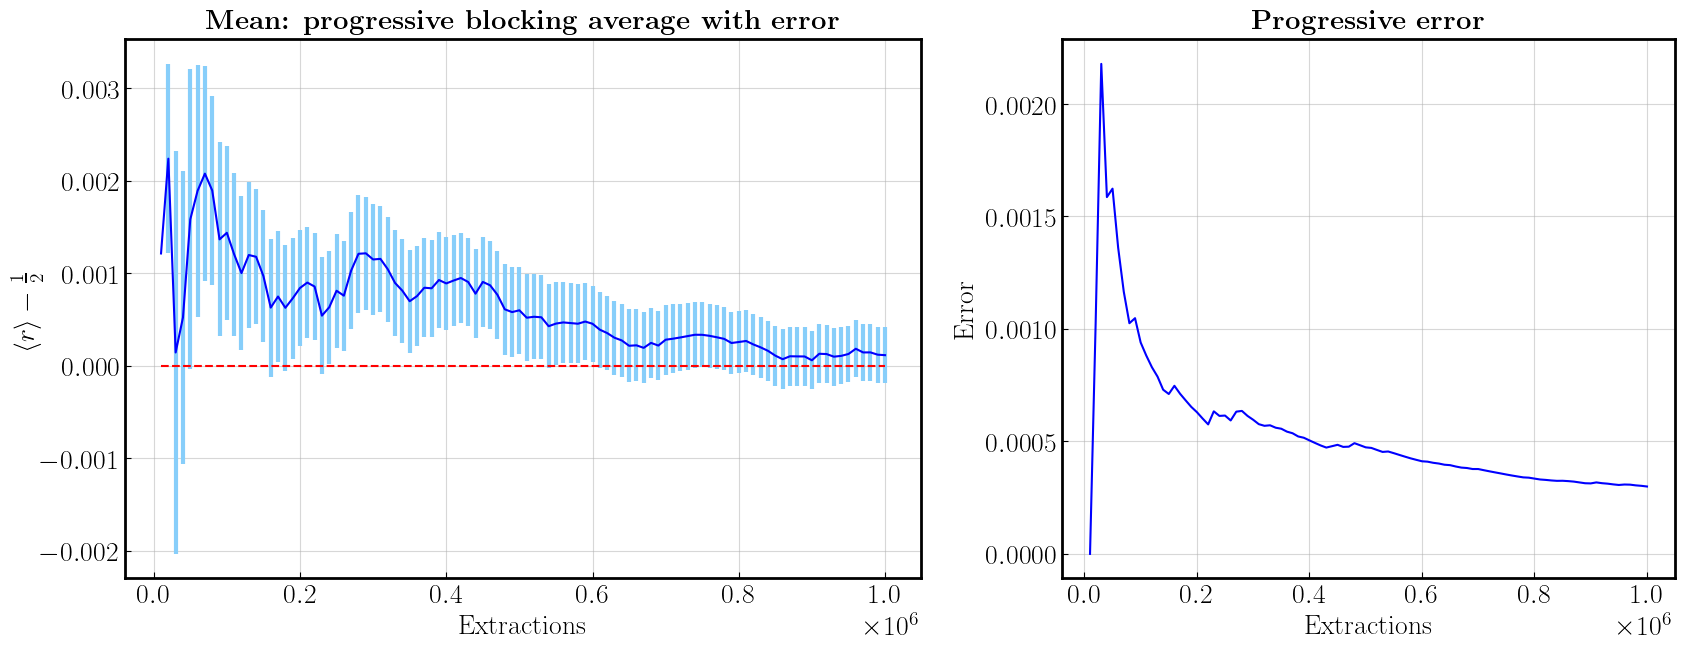

In [60]:
# plot mean
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})


axs[0].errorbar(data[:,0], data[:,2], yerr=data[:,3], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3)
zero = np.zeros(data.shape[0])
axs[0].plot(data[:,0], zero, linestyle='--', color='red')

axs[0].set_title(r'\textbf{Mean: progressive blocking average with error}', pad=8)
axs[0].set_xlabel('Extractions')
axs[0].set_ylabel(r'$\langle r \rangle - \frac{1}{2}$', labelpad=-2)

axs[1].plot(data[:,0], data[:,3], color='blue')
axs[1].set_title(r'\textbf{Progressive error}', pad=8)
axs[1].set_xlabel('Extractions')
axs[1].set_ylabel('Error', labelpad=6)

plt.show()

This plots show the progressive mean value $\langle r \rangle - 1/2$ with its error and also the progressive value of the error itself. You can notice that $\langle r \rangle$ is within one $\sigma$ from the expected value $1/2$.

**Plot parameters**:
- Extractions: $10^6$
- Blocks: $10^2$
- Extractions in each block: $10^4$

### Variance
The variance of a random number $r$ can be computed as $\sigma^2 = \int_0^1 (r-1/2)^2 dr$. I calculated it with the blocking method and I compared the result with the expectation value $1/12$.

To compute the blocking average I implemented the class `BA_Variance`.

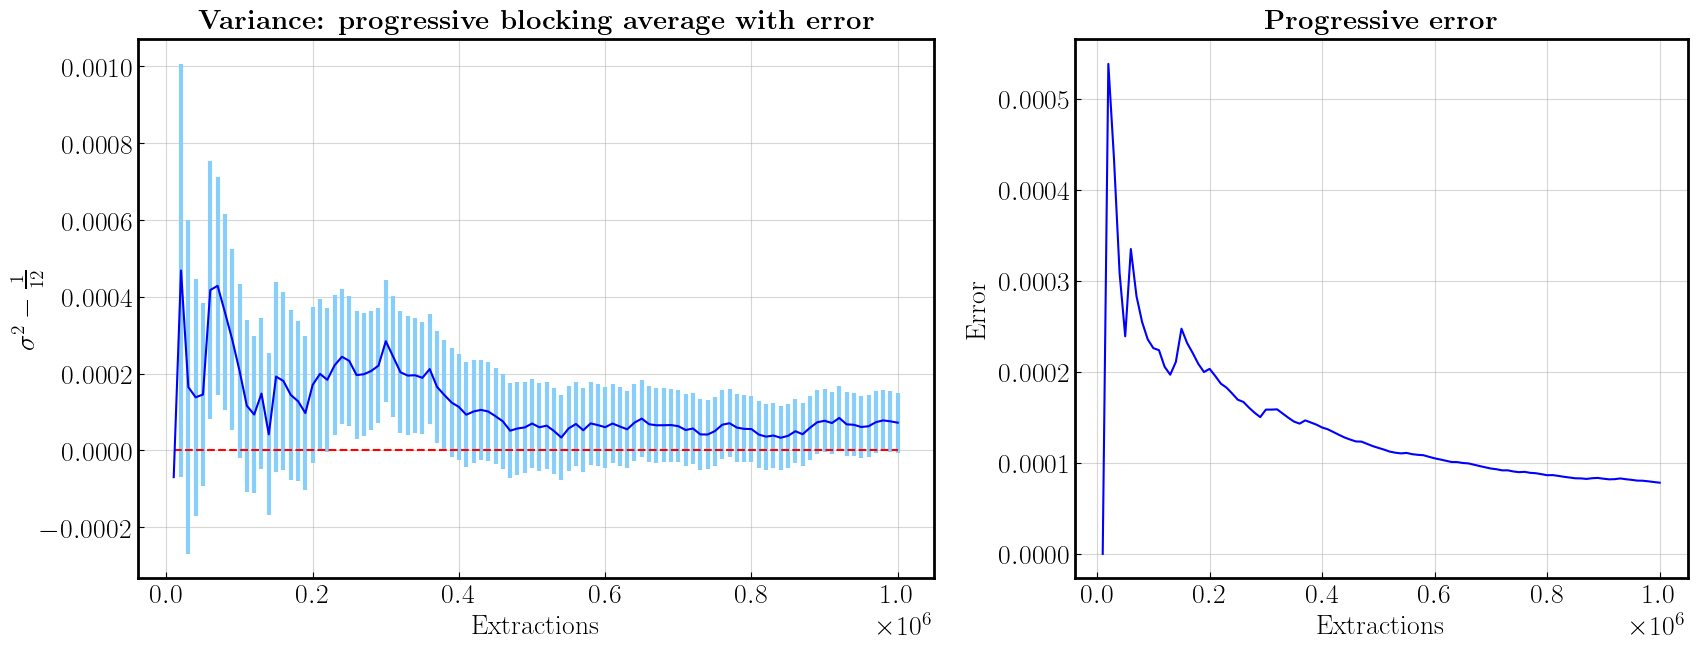

In [61]:
# plot variance
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})


axs[0].errorbar(data[:,0], data[:,4], yerr=data[:,5], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3)
zero = np.zeros(data.shape[0])
axs[0].plot(data[:,0], zero, linestyle='--', color='red')

axs[0].set_title(r'\textbf{Variance: progressive blocking average with error}', pad=8)
axs[0].set_xlabel('Extractions')
axs[0].set_ylabel(r'$\sigma^2 - \frac{1}{12}$', labelpad=-2)

axs[1].plot(data[:,0], data[:,5], color='blue')
axs[1].set_title(r'\textbf{Progressive error}', pad=8)
axs[1].set_xlabel('Extractions')
axs[1].set_ylabel('Error', labelpad=6)

plt.show()

This plots show the progressive mean value $\langle \sigma^2 \rangle - 1/12$ with its error and also the progressive value of the error itself. $\langle \sigma^2 \rangle$ is within one $\sigma$ from the expected value $1/2$.

**Plot parameters**:
- Extractions: $10^6$
- Blocks: $10^2$
- Extractions in each block: $10^4$

### $\chi^2$

The $\chi^2$ test is used to verify that some data follow a specific distribution: here we want to verify that the pseudo-random numbers generator gives values uniformly distributed. To compute the $\chi^2$:

$$ \chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M} \ , $$

I divided the interval $[0,1)$ in $M=100$ sub-intervals, and then I extracted $n=10^4$ random numbers for $100$ times, counting how many points fall into each sub interval at every iteration of the process. For a uniform distribution, the expected value of points per sub-interval is exactly $n/M = 100$.

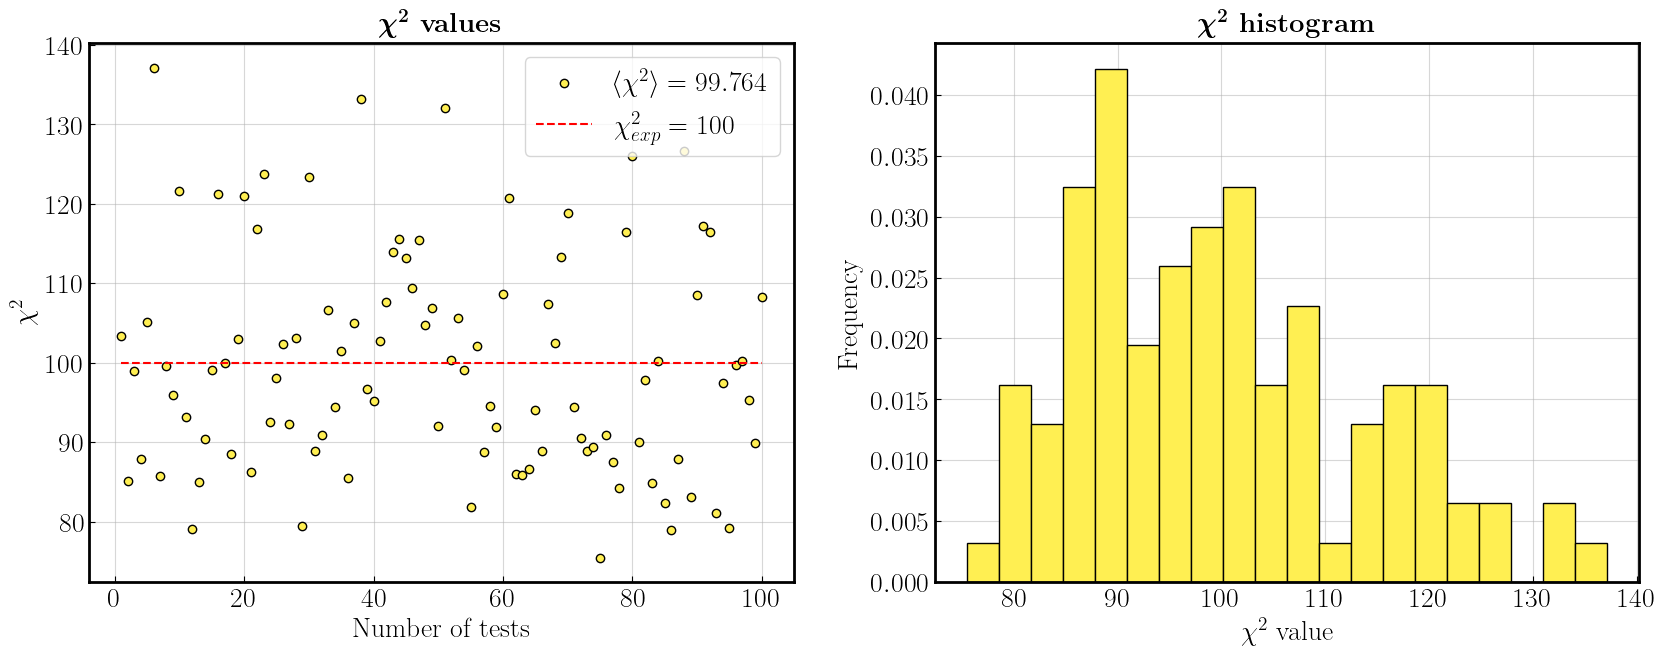

In [62]:
# plot chi2
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].scatter(data[:,1], data[:,6], facecolor='#FFEF52', label=r'$\langle \chi^2 \rangle = ' + '{:.3f}'.format(np.mean(data[:,6])) + r'$')
chi_exp = 100*np.ones(data.shape[0])
axs[0].plot(data[:,1], chi_exp, linestyle='--', color='red', label='$\chi^2_{exp} = 100$')
axs[0].set_title(r'\textbf{\boldmath$\chi^2$ values}', pad=8)
axs[0].set_xlabel('Number of tests')
axs[0].set_ylabel('$\chi^2$', labelpad=6)
axs[0].legend()

axs[1].hist(data[:,6], bins=20, color='#FFEF52', edgecolor='black', density=True)
axs[1].set_title(r'\textbf{\boldmath$\chi^2$ histogram}', pad=8)
axs[1].set_xlabel('$\chi^2$ value')
axs[1].set_ylabel('Frequency', labelpad=6)

plt.show()

Here I computed the $chi^2$ test a larger number of times: I extracted $n=10^4$ points for $10^4$ times, using always $M=100$ sub-intervals, to verify the correct distribution of the $\chi^2$ variable.

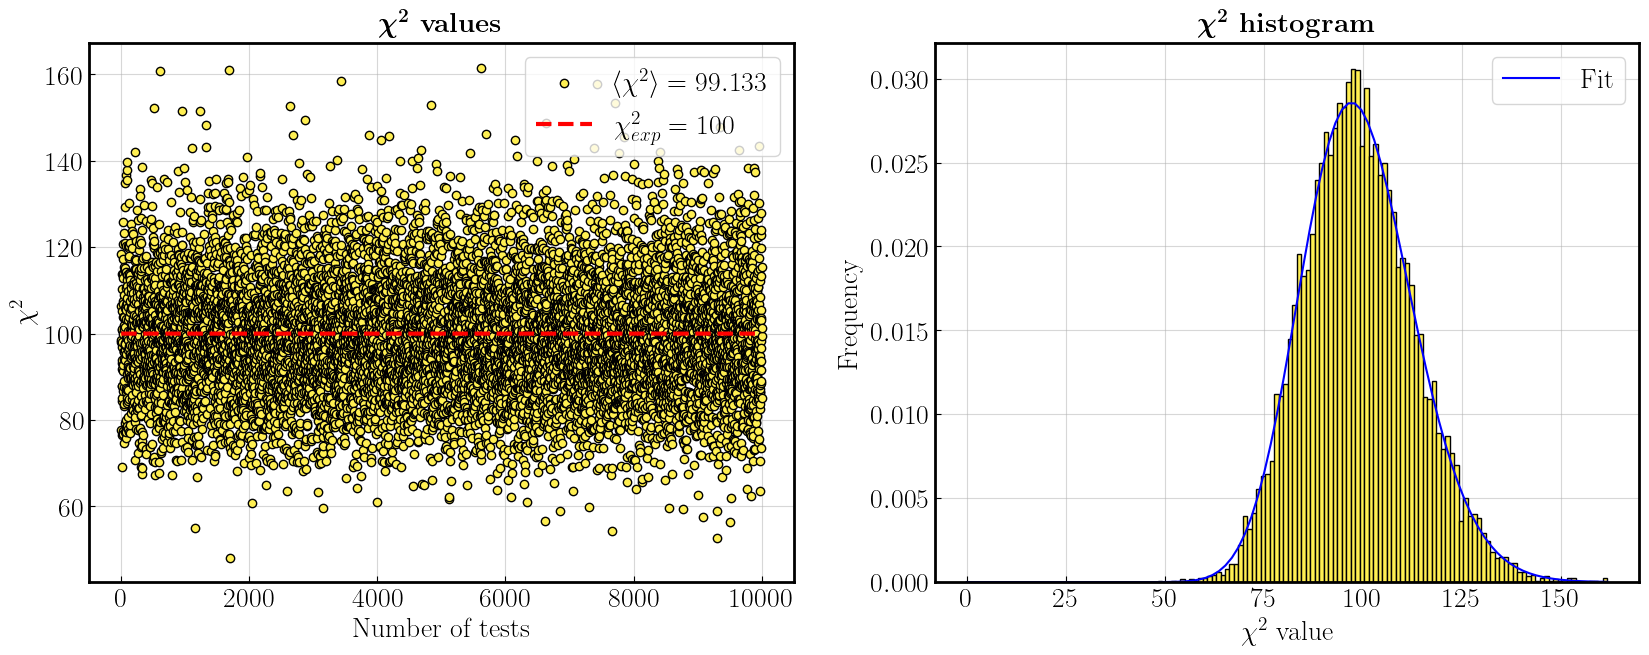

In [63]:
# plot chi2 with may points
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].scatter(chi[:,0], chi[:,1], facecolor='#FFEF52', label=r'$\langle \chi^2 \rangle = ' + '{:.3f}'.format(np.mean(chi[:,1])) + r'$')
chi_exp = 100*np.ones(chi.shape[0])
axs[0].plot(chi[:,0], chi_exp, ls='--', lw=3,  color='red', label='$\chi^2_{exp} = 100$')
axs[0].set_title(r'\textbf{\boldmath$\chi^2$ values}', pad=8)
axs[0].set_xlabel('Number of tests')
axs[0].set_ylabel('$\chi^2$', labelpad=6)
axs[0].legend()

# histogram and fit
hist, bins = np.histogram(chi[:,1], bins=100, density=True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(chi2.pdf, binscenters, hist, p0=99)
x = np.linspace(0, np.max(bins), 100)

axs[1].hist(chi[:,1], bins=100, color='#FFEF52', edgecolor='black', density=True)
axs[1].plot(x, chi2.pdf(x, *popt), color='blue', label='Fit')
axs[1].set_title(r'\textbf{\boldmath$\chi^2$ histogram}', pad=8)
axs[1].set_xlabel('$\chi^2$ value')
axs[1].set_ylabel('Frequency', labelpad=6)
axs[1].legend()

plt.show()

# Exercise 01.2

**Extend Pseudo-Random Number generator downloaded from the NSL Ariel web site and check the Central Limit Theorem**

1. Add two probability distributions by using the **method of the inversion of the cumulative distribution** to sample from a **generic** exponential distribution, $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Exponential_distribution">this Wikipedia link</a>), and a **generic** Cauchy-Lorentz distribution $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-\infty;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Cauchy_distribution">this Wikipedia link</a>).
2. Make 3 picture with the histograms obtained filling them with $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), being $x_i$ a random variable sampled throwing a *standard* dice (fig.1), an *exponential* dice (fig.2, use $\lambda=1$) and a *Lorentzian* dice (fig.3, use $\mu=0$ and $\Gamma=1$).

Note tha you can try to fit the case $N=100$ with a Gaussian for standard and exponential dices, whereas you should use a Cauchy-Lorentz distribution for the last case.

## Solution

The **Central Limit Theorem (CLT)** states that, given a set of independent and identically-distributed random variables with finite mean and variance, their sum will follow a Gaussian distribution, regardless of the single distributions.

In this exercise I use the random numbers generator to extract some numbers from a given distribution, and then I compute their sums $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ with $N=1, 2, 10, 100$, all repeated for $10^4$ times. I then showed the validity of the CLT for **uniform** and **exponential** distributions. I showed also that the CLT does not hold in the case of the **Cauchy-Lorentz** distribution, because it has infinite variance.

### Cumulative inverse method

To sample a non-trivial probability distribution using numbers extracted from a uniform distribution in the range $[0,1)$, I exploited the method of the inversion of the cumulative distribution. Given a probability distribution $p(x)$, its cumulative distribution is:

$$ F(x) = \int_{-\infty}^x p(t) dt \ , $$

and the value of the integral assumes values in the range $[0,1]$. So we can consider a random variable $y=F(x)$ uniformly distributed in $[0,1)$ and so obtain $x$ (i.e. a sample of $p(x)$) by inverting the cumulative function $F(x)$:

$$ x = F^{-1}(y) \ . $$

### Uniform distribution

In [64]:
unif = np.loadtxt('01.2/uniform.csv', delimiter=',', skiprows=1)
unif = unif[np.argsort(unif[:,0])]

In [65]:
# definition of the fiting function

def gauss_distr(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

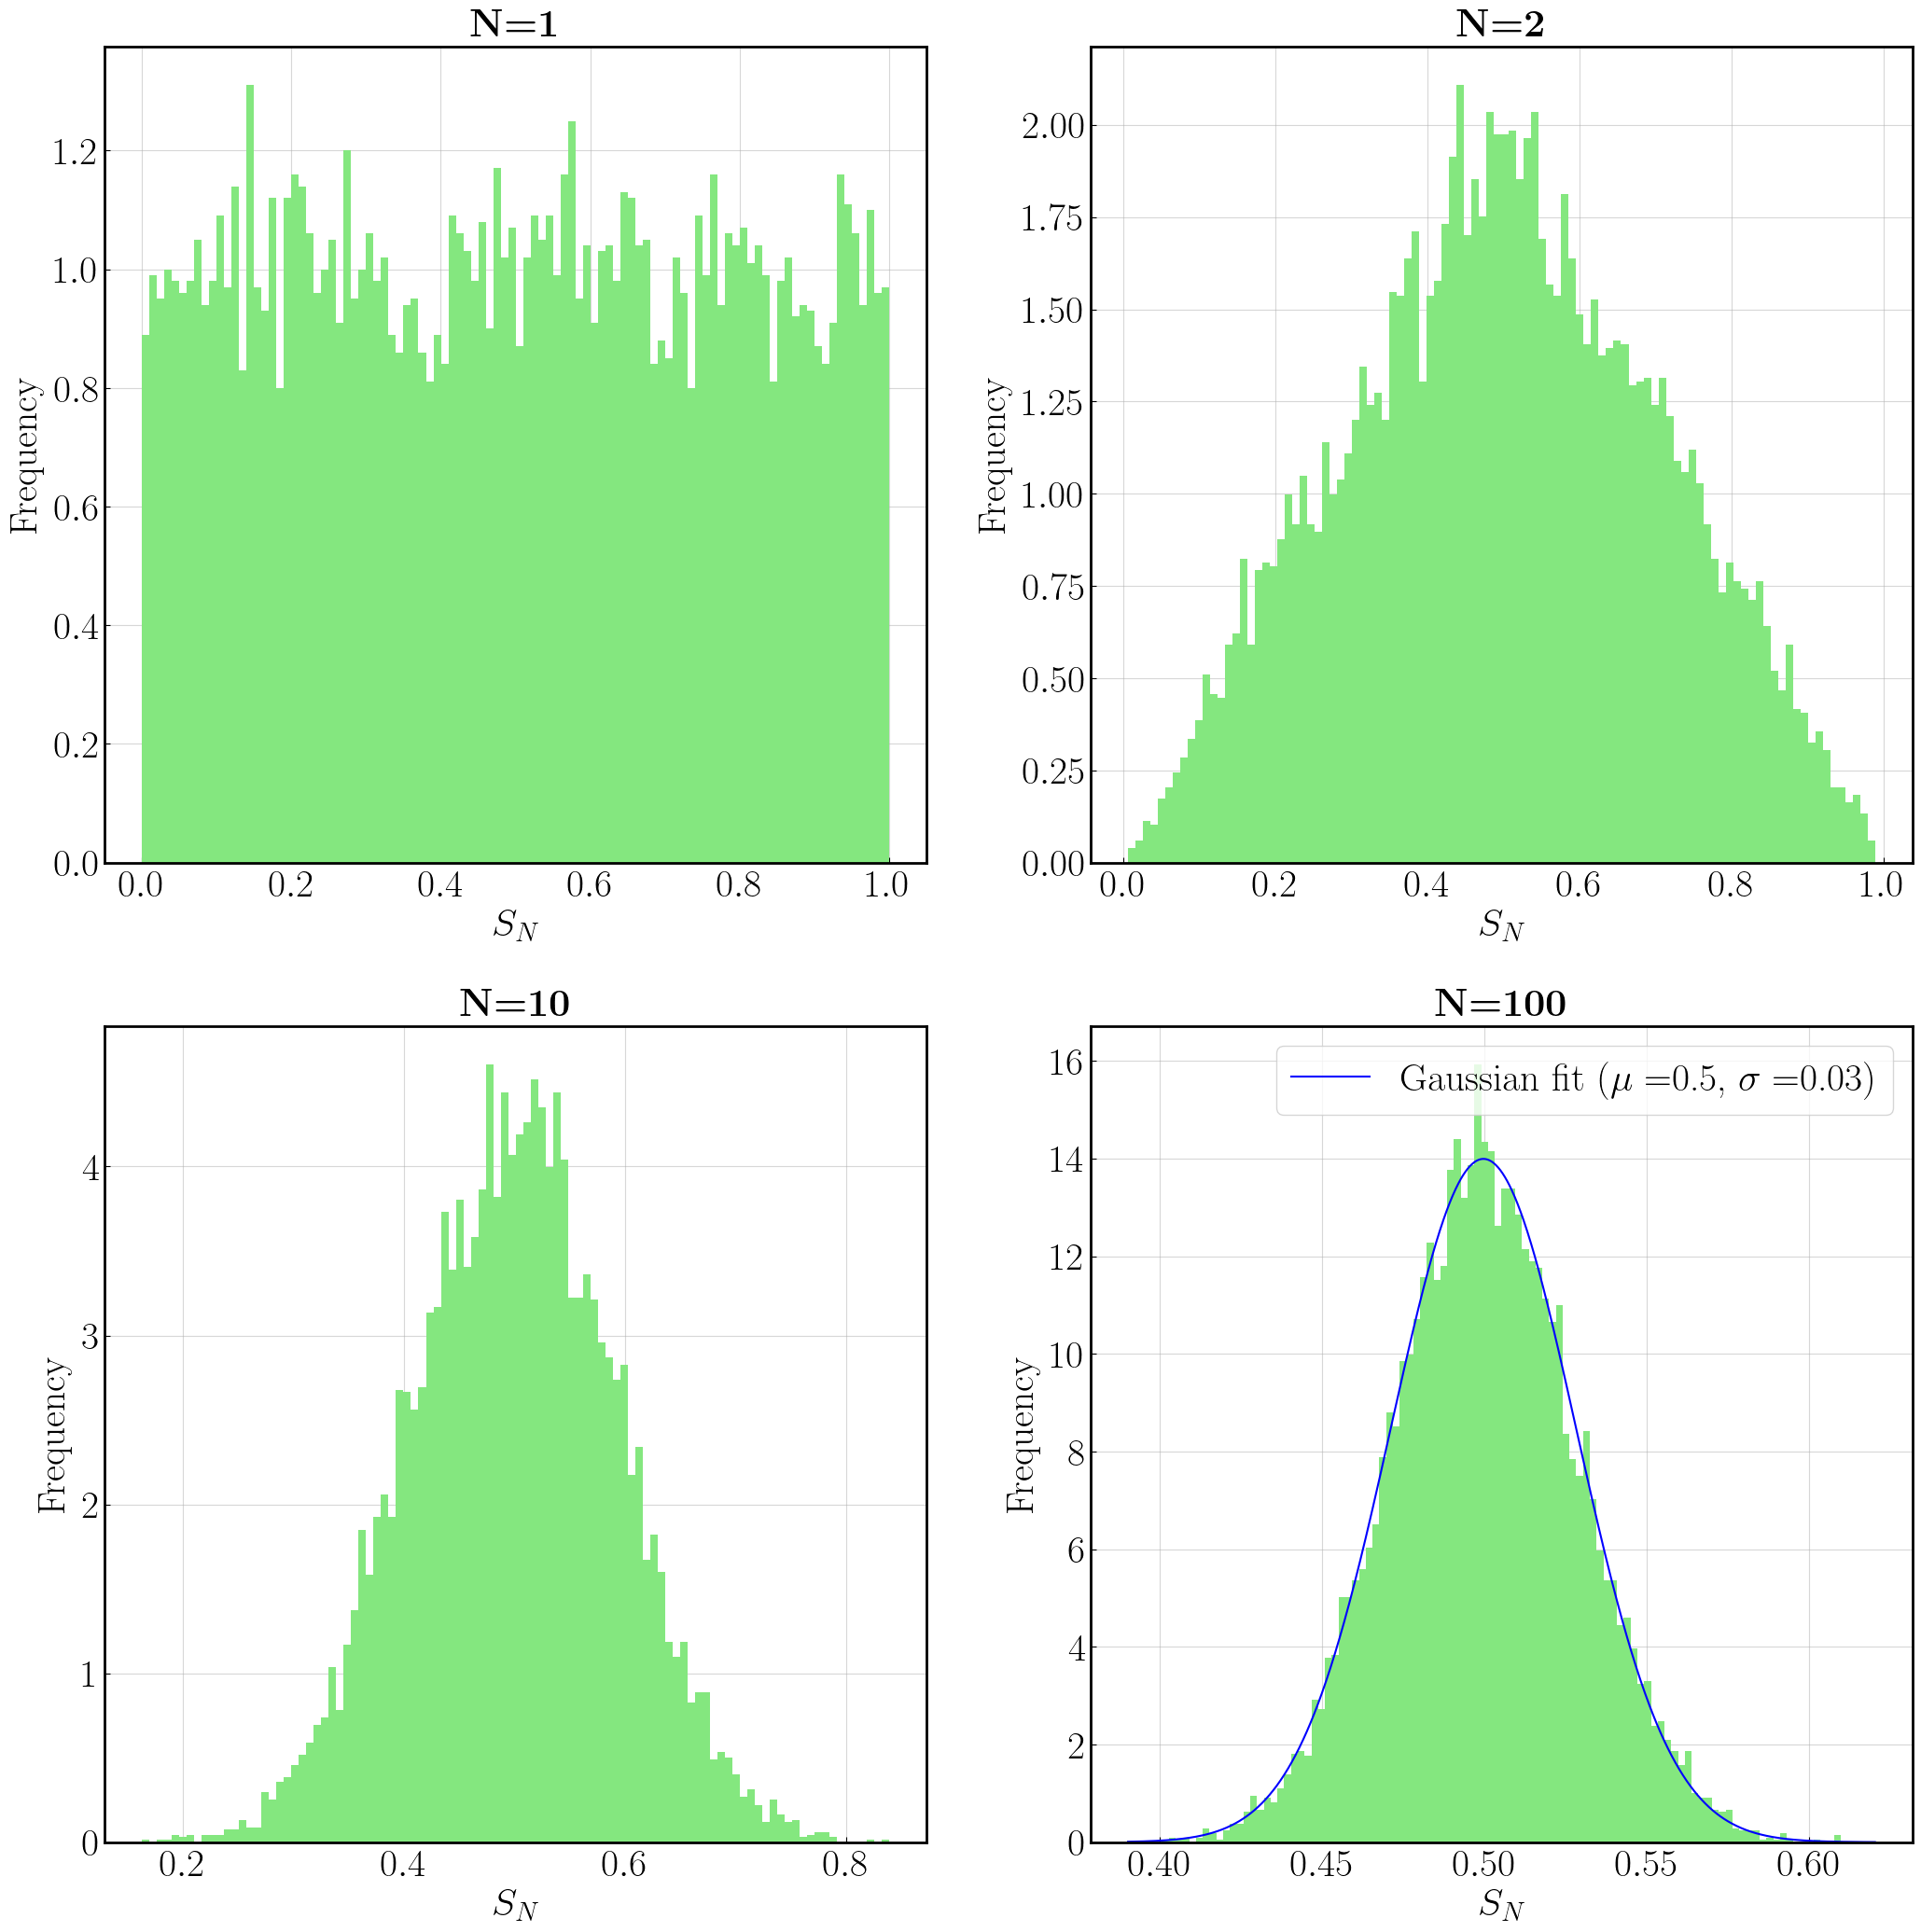

In [66]:
# plotting the hystograms

nbin = 100
color = '#84E77F'
size = 30

fig, axs = plt.subplots(2, 2, figsize=(25, 25))

axs[0,0].hist(unif[:10000,2], bins=nbin, color=color, density = True)
axs[0,0].set_title(r'\textbf{N=1}', fontsize=size, pad=8)

axs[0,1].hist(unif[10000:20000,2], bins=nbin, color=color, density = True)
axs[0,1].set_title(r'\textbf{N=2}', fontsize=size, pad=8)

axs[1,0].hist(unif[20000:30000,2], bins=nbin, color=color, density = True)
axs[1,0].set_title(r'\textbf{N=10}', fontsize=size, pad=8)

axs[1,1].hist(unif[30000:40000,2], bins=nbin, color=color, density = True)
axs[1,1].set_title(r'\textbf{N=100}', fontsize=size, pad=8)

for i in range(2) :
    for j in range(2) :
        axs[i,j].set_xlabel('$S_N$', fontsize=size)
        axs[i,j].set_ylabel('Frequency', fontsize=size, labelpad=8)
        axs[i,j].tick_params(axis='y', labelsize=size)
        axs[i,j].tick_params(axis='x', labelsize=size, pad=5)


# fit with a normal distribution

xlim = axs[1,1].get_xlim()
bins = np.linspace(xlim[0], xlim[1], 10001)
data_entries, bins = np.histogram(unif[30000:40000,2], bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(gauss_distr, binscenters, data_entries)
x = np.linspace(xlim[0], xlim[1], 1000)
y_fit = gauss_distr(x, *popt)

axs[1,1].plot(x, y_fit, color='blue', label='Gaussian fit ($\mu=$' + str(round(popt[0],2)) + ', $\sigma=$' + str(round(popt[1],2)) + ')')
axs[1,1].legend(fontsize=size)


plt.show()

### Exponential distribution

Given $p(x) = \lambda e^{-\lambda x}$, by using the cumulative inverse method, we have:

$$ F(x) = \int_{-\infty}^x p(t) dt = 1 - e^{-\lambda x} \ , $$

$$ x = -\frac{1}{\lambda} \ln(1 - F(x)) \ . $$


In [67]:
expo = np.loadtxt('01.2/exponential.csv', delimiter=',', skiprows=1)
expo = expo[np.argsort(expo[:,0])]

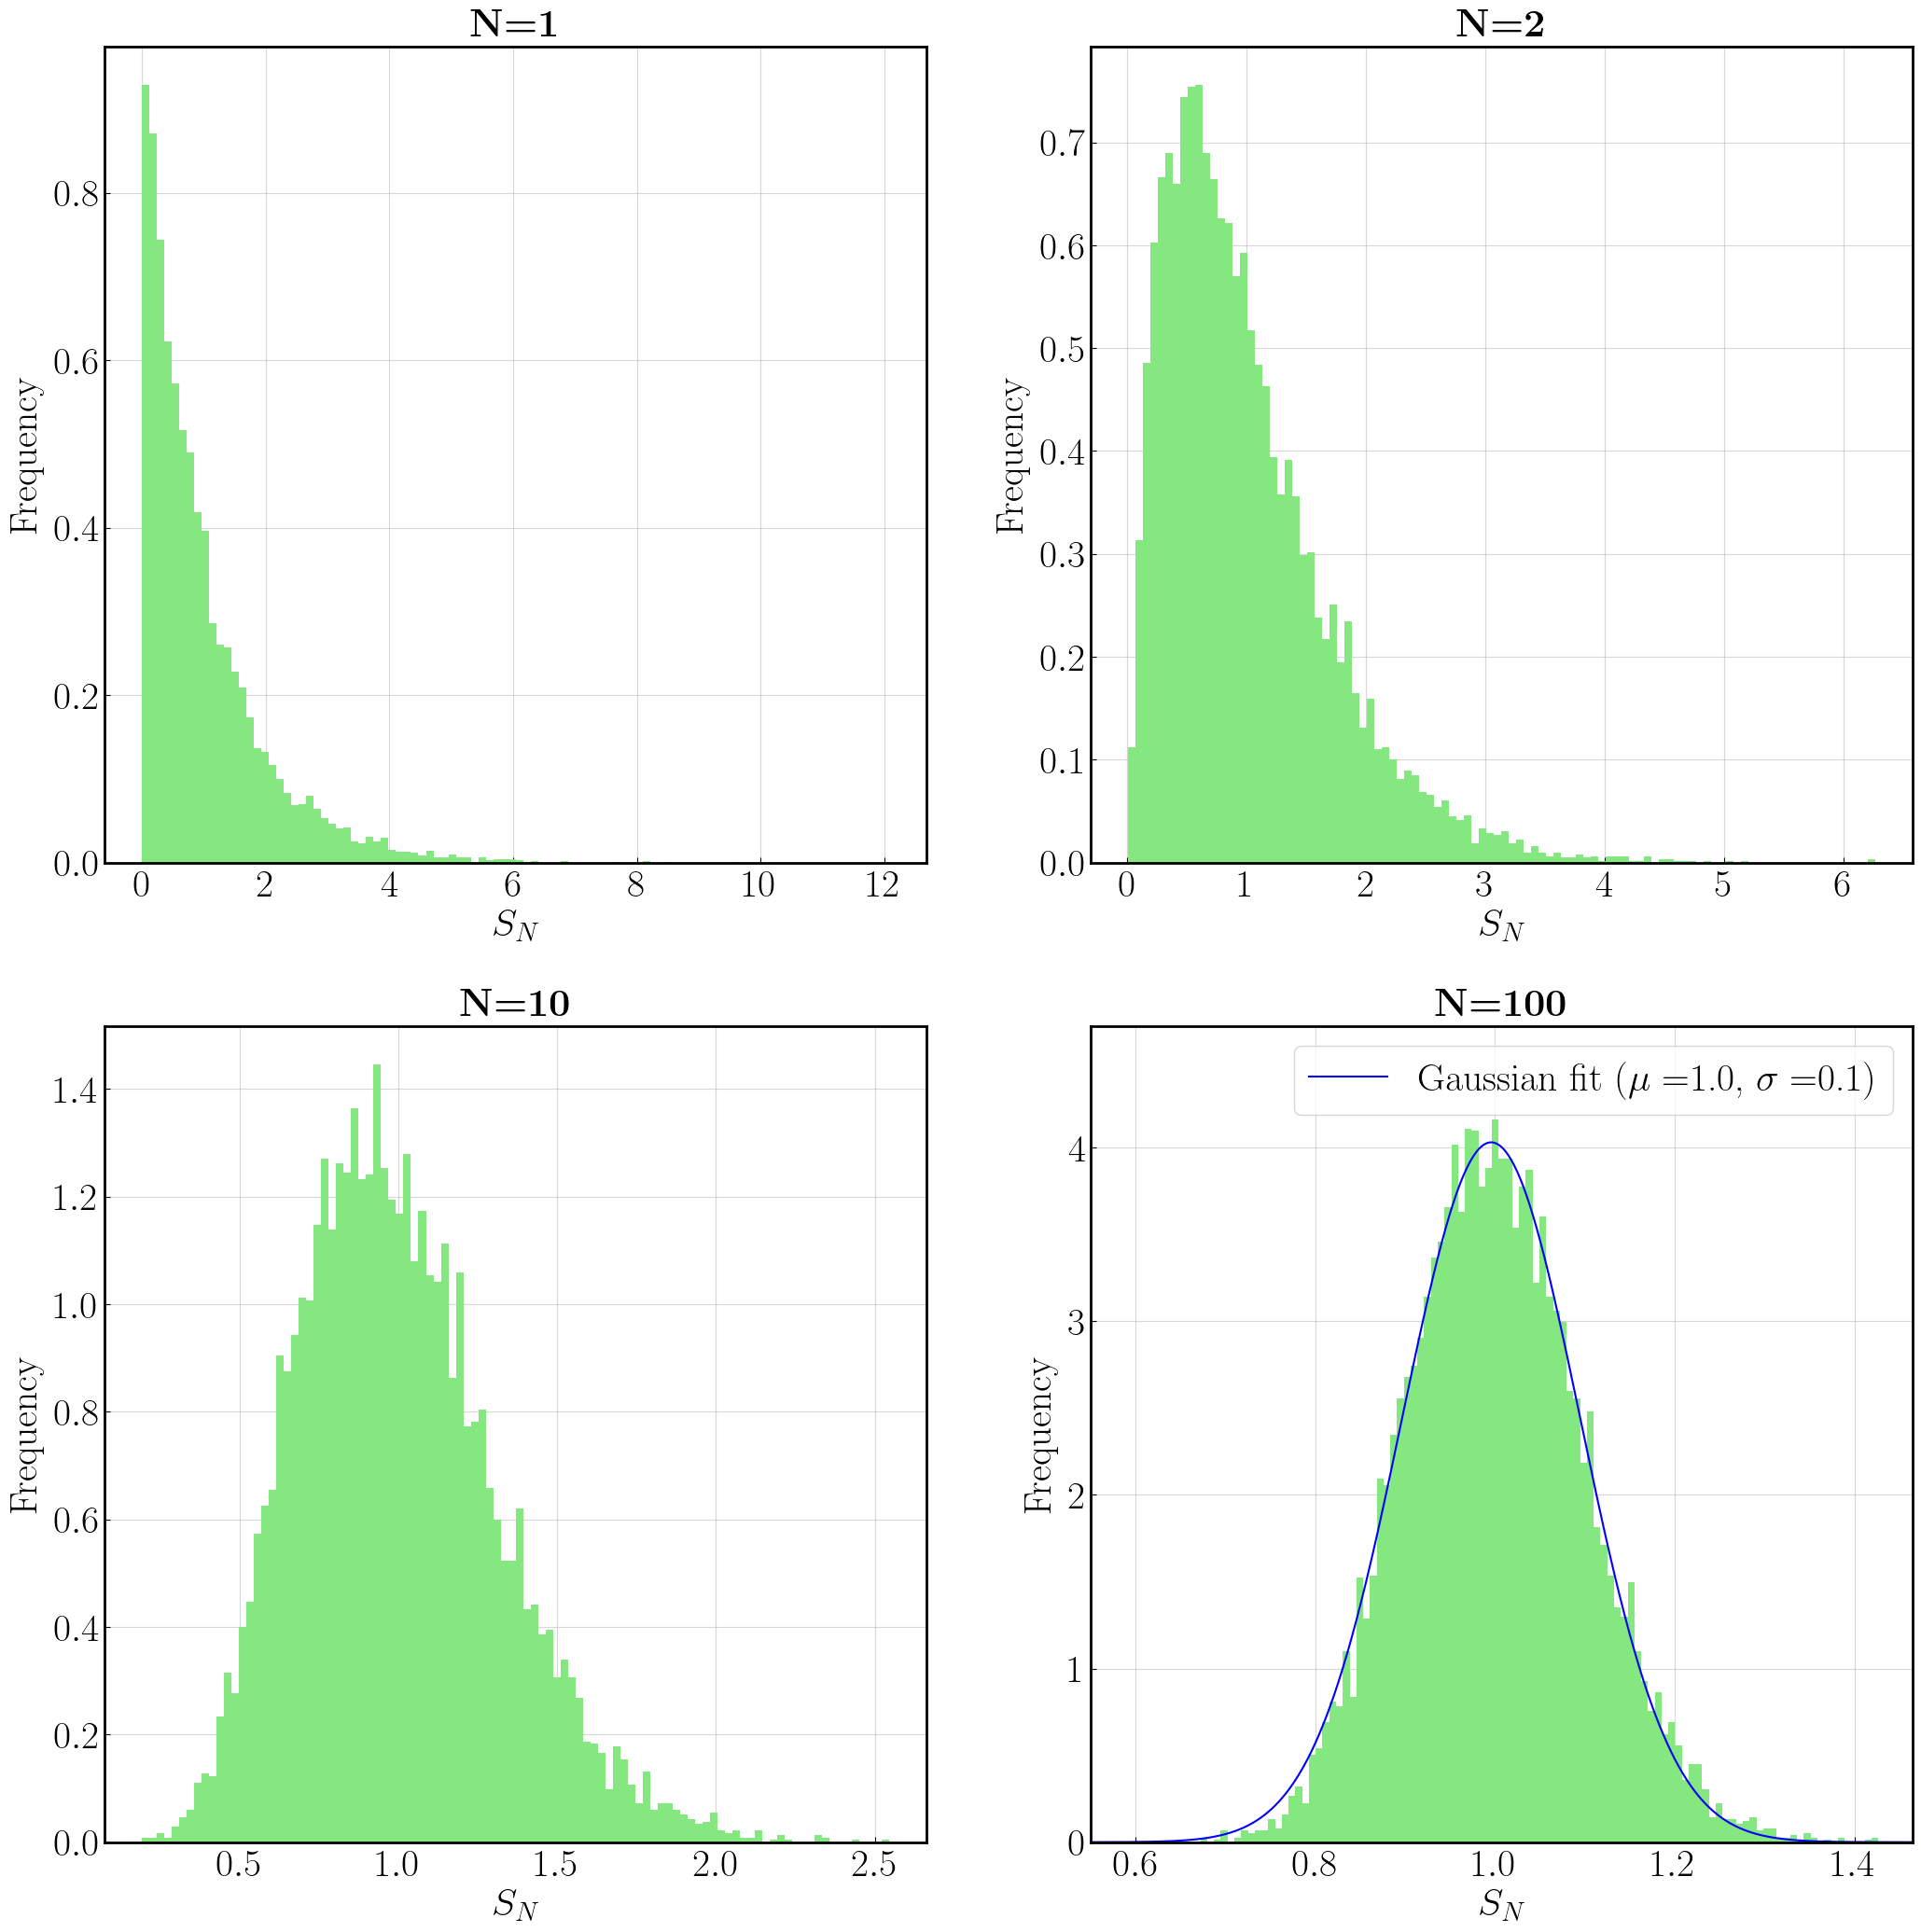

In [68]:
# plotting the hystograms

nbin = 100
color = '#84E77F'
size = 30

fig, axs = plt.subplots(2, 2, figsize=(25, 25))

axs[0,0].hist(expo[:10000,2], bins=nbin, color=color, density = True)
axs[0,0].set_title(r'\textbf{N=1}', fontsize=size, pad=8)

axs[0,1].hist(expo[10000:20000,2], bins=nbin, color=color, density = True)
axs[0,1].set_title(r'\textbf{N=2}', fontsize=size, pad=8)

axs[1,0].hist(expo[20000:30000,2], bins=nbin, color=color, density = True)
axs[1,0].set_title(r'\textbf{N=10}', fontsize=size, pad=8)

axs[1,1].hist(expo[30000:40000,2], bins=nbin, color=color, density = True)
axs[1,1].set_title(r'\textbf{N=100}', fontsize=size, pad=8)
axs[1,1].set_ylim(axs[1,1].get_ylim()[0], 4.7)
axs[1,1].set_xlim(0.55, axs[1,1].get_xlim()[1])

for i in range(2) :
    for j in range(2) :
        axs[i,j].set_xlabel('$S_N$', fontsize=size)
        axs[i,j].set_ylabel('Frequency', fontsize=size, labelpad=8)
        axs[i,j].tick_params(axis='y', labelsize=size)
        axs[i,j].tick_params(axis='x', labelsize=size, pad=5)


# fit with a normal distribution

xlim = axs[1,1].get_xlim()
bins = np.linspace(xlim[0], xlim[1], 10001)
data_entries, bins = np.histogram(expo[30000:40000,2], bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(gauss_distr, binscenters, data_entries)
x = np.linspace(xlim[0], xlim[1], 1000)
y_fit = gauss_distr(x, *popt)

axs[1,1].plot(x, y_fit, color='blue', label='Gaussian fit ($\mu=$' + str(round(popt[0],2)) + ', $\sigma=$' + str(round(popt[1],2)) + ')')
axs[1,1].legend(fontsize=size)


plt.show()

### Cauchy-Lorentz distribution

Given $p(x) = \dfrac{1}{\pi} \dfrac{\Gamma}{(x-\mu)^2 + \Gamma^2}$, by using the cumulative inverse method, we have:

$$ F(x) = \int_{-\infty}^x p(t) dt = \frac{1}{\pi} \arctan\left(\frac{x-\mu}{\Gamma}\right) + \frac{1}{2} \ , $$

$$ x = \Gamma \, \tan \left[ \pi \left( F(x) - \frac{1}{2} \right) \right] + \mu \ .$$

In [69]:
calo = np.loadtxt('01.2/cauchy-lorentz.csv', delimiter=',', skiprows=1)
calo = calo[np.argsort(calo[:,0])]

In [70]:
# definition of the fitting function

def cau_lor_distr(x, mu, gamma):
    return cauchy.pdf(x, mu, gamma)

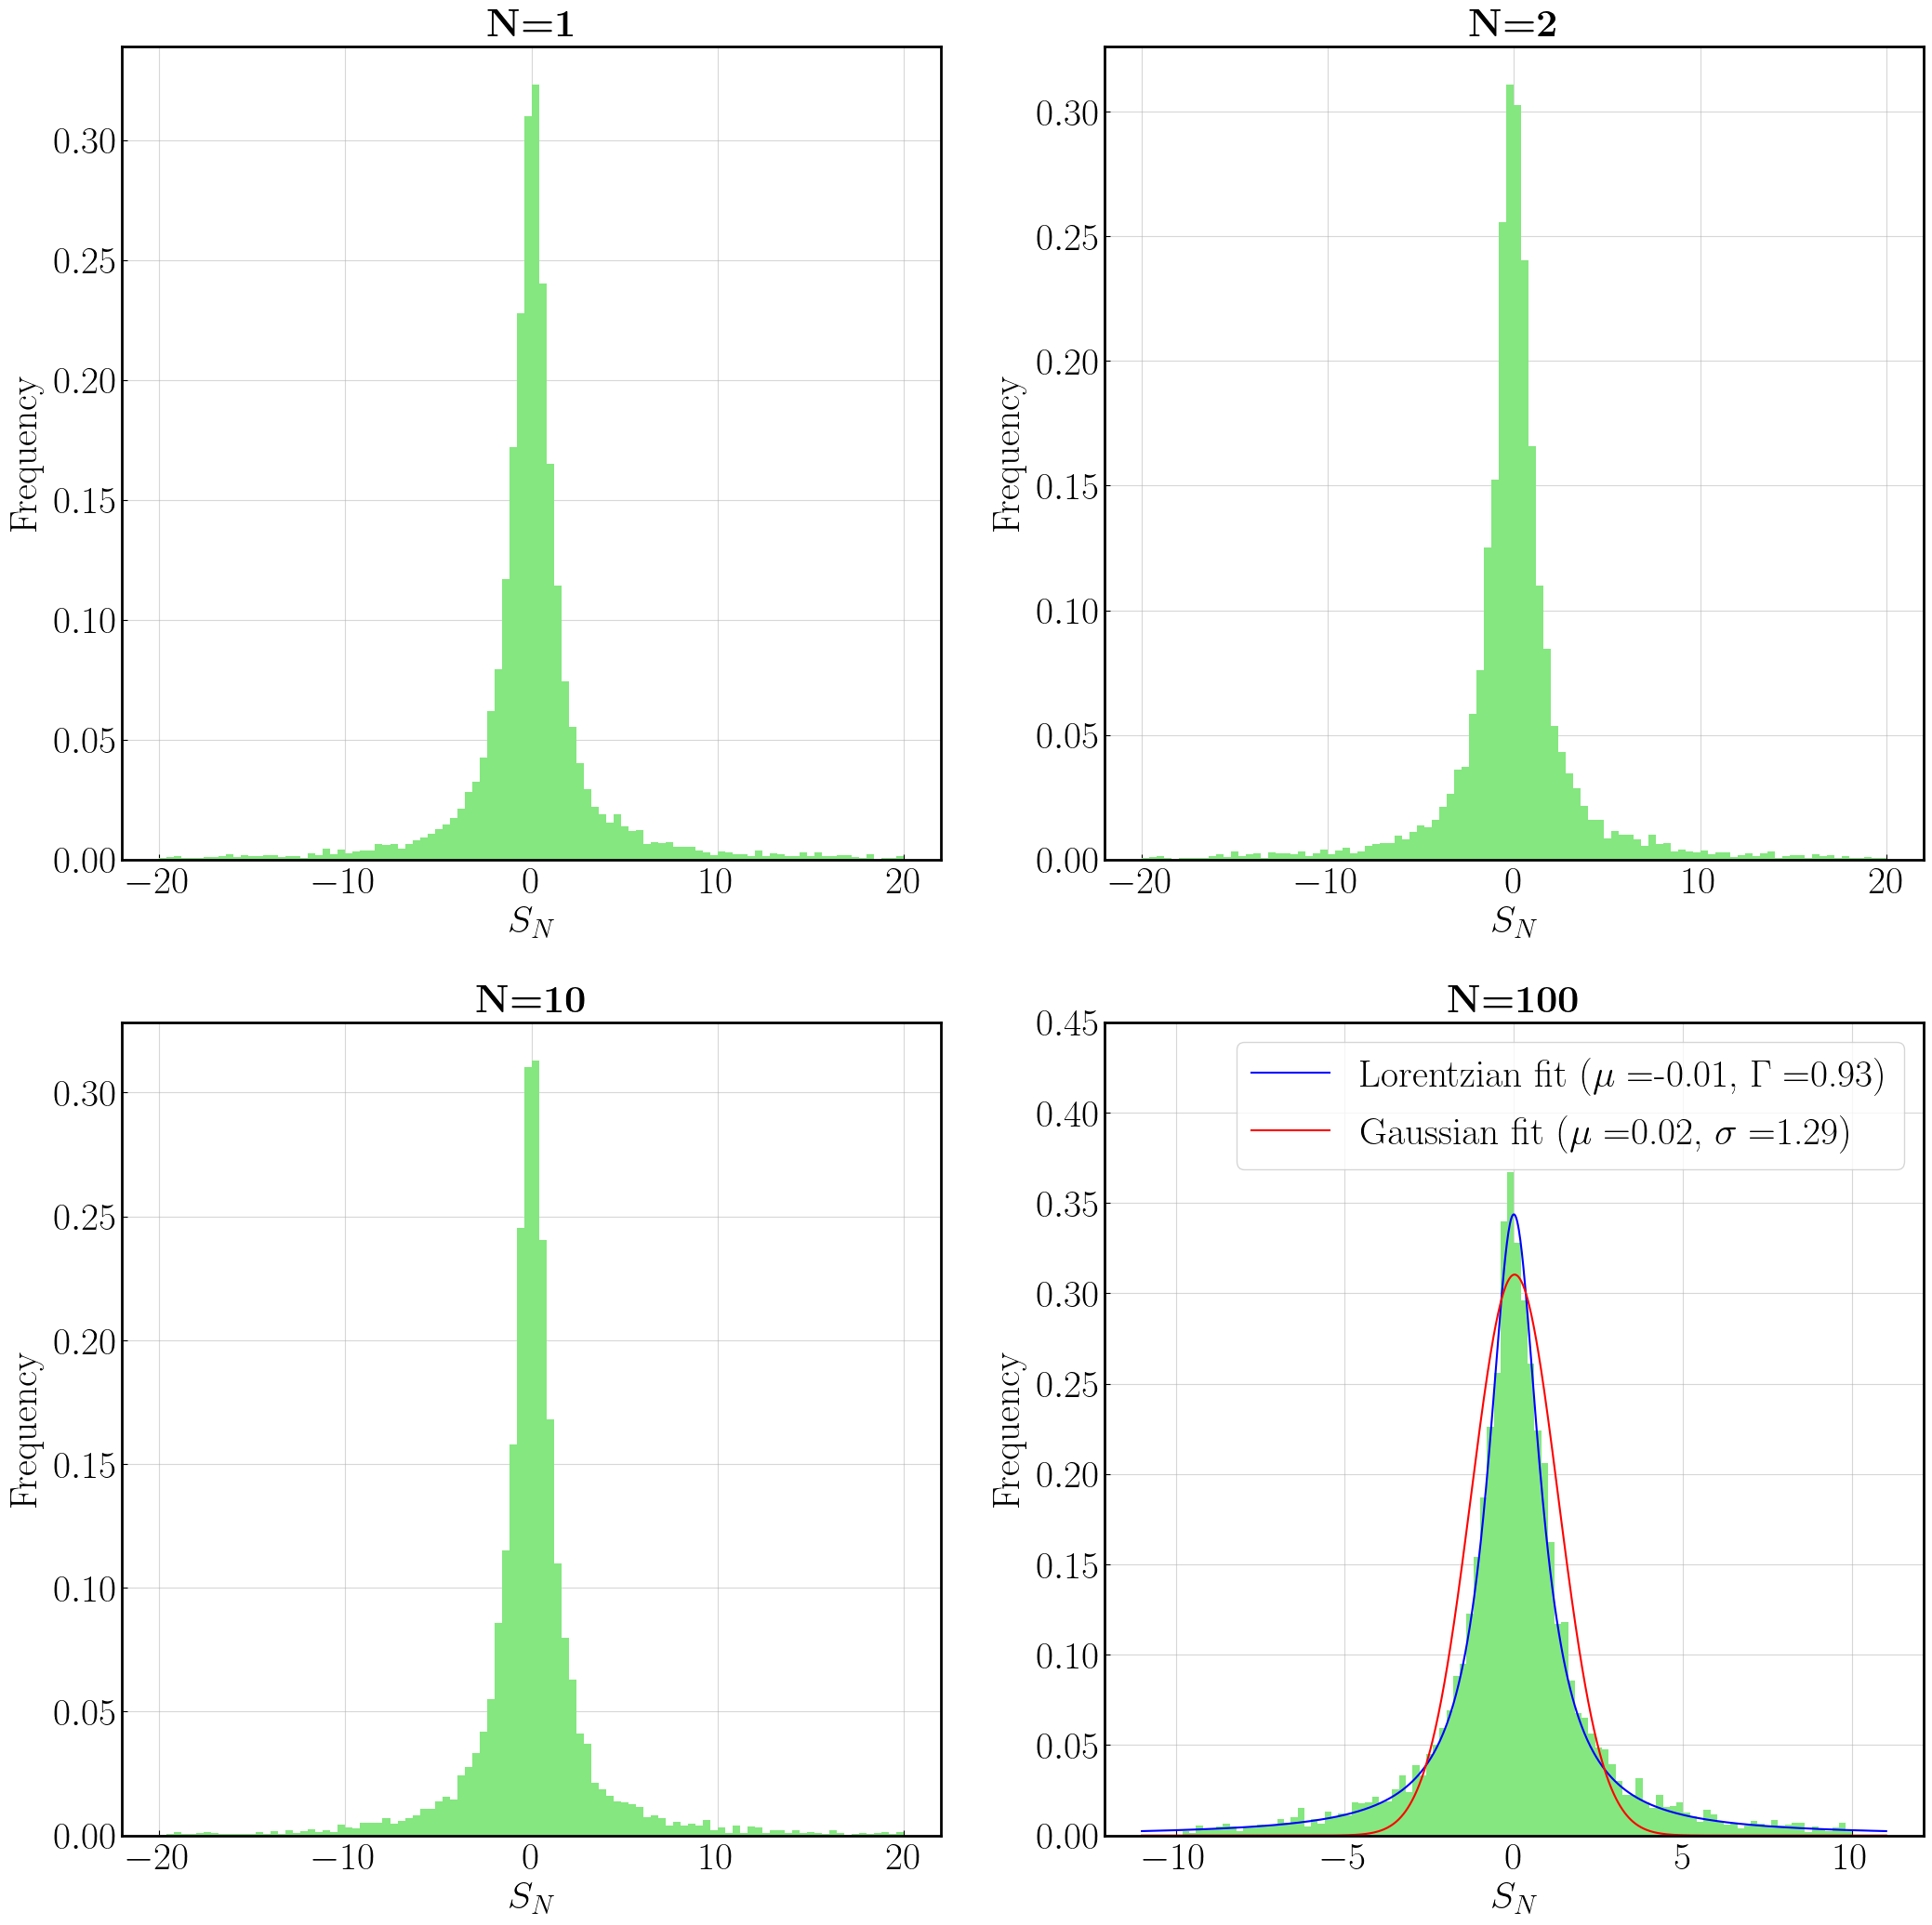

In [71]:
# plotting the hystograms

nbin = 100
color = '#84E77F'
size = 30

fig, axs = plt.subplots(2, 2, figsize=(25, 25))

axs[0,0].hist(calo[:10000,2], bins=nbin, color=color, density = True, range = (-20, 20))
axs[0,0].set_title(r'\textbf{N=1}', fontsize=size, pad=8)

axs[0,1].hist(calo[10000:20000,2], bins=nbin, color=color, density = True, range = (-20, 20))
axs[0,1].set_title(r'\textbf{N=2}', fontsize=size, pad=8)

axs[1,0].hist(calo[20000:30000,2], bins=nbin, color=color, density = True, range = (-20, 20))
axs[1,0].set_title(r'\textbf{N=10}', fontsize=size, pad=8)

axs[1,1].hist(calo[30000:40000,2], bins=nbin, color=color, density = True, range = (-10, 10))
axs[1,1].set_title(r'\textbf{N=100}', fontsize=size, pad=8)
axs[1,1].set_ylim(axs[1,1].get_ylim()[0], 0.45)

for i in range(2) :
    for j in range(2) :
        axs[i,j].set_xlabel('$S_N$', fontsize=size)
        axs[i,j].set_ylabel('Frequency', fontsize=size, labelpad=8)
        axs[i,j].tick_params(axis='y', labelsize=size)
        axs[i,j].tick_params(axis='x', labelsize=size, pad=5)


# fit with a normal distribution

xlim = axs[1,1].get_xlim()
bins = np.linspace(xlim[0], xlim[1], 10001)
data_entries, bins = np.histogram(calo[30000:40000,2], bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(cau_lor_distr, binscenters, data_entries)
popt2, pcov2 = curve_fit(gauss_distr, binscenters, data_entries)
x = np.linspace(xlim[0], xlim[1], 1000)
y_fit = cau_lor_distr(x, *popt)
y_fit2 = gauss_distr(x, *popt2)

axs[1,1].plot(x, y_fit, color='blue', label='Lorentzian fit ($\mu=$' + str(round(popt[0],2)) + ', $\Gamma=$' + str(round(popt[1],2)) + ')')
axs[1,1].plot(x, y_fit2, color='red', label='Gaussian fit ($\mu=$' + str(round(popt2[0],2)) + ', $\sigma=$' + str(round(popt2[1],2)) + ')')
axs[1,1].legend(fontsize=size)


plt.show()

# Exercise 01.3

**Buffon's experiment**

- **Simulate** the Buffon’s experiment (see LSN_Lecture_00, supplementary material):  A needle of length $L$ is thrown at random onto a horizontal plane ruled with straight lines a distance $d$ (must be $d > L$, but do not use $d\gg L$ otherwise $P\ll 1$) apart. The probability $P$ that the needle will intersect one of these lines is: $P = 2L/\pi d$. This could be used to evaluate $\pi$ from throws of the needle: if the needle is thrown down $N_{thr}$ times and is observed to land on a line $N_{hit}$ of those times, we can make an estimate of $\pi$ from
$$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$
Make a picture of the estimation of $\pi$ and its uncertainty (Standard Deviation of the mean) with a large number of *throws* $M$ as a function of the number of blocks, $N$. If possible, do not use $\pi$ to evaluate $\pi$.

## Solution

To simulate Buffon's experiment I considered a plane divided by horizontal lines at distance $d=1.1$ and a needle of length $l=1$. I then used the random numbers generator to extract the position of one end of the needle uniformly in range $[0,d)$ and the angle in range $[0,2\pi)$. Then I evaluated the number of times that the needle hits the lines, and I used the class `BA_Buffon` to compute the blocking average of the quantity:

$$ \frac{2LN_{thr}}{N_{hit}d} \to \pi \ . $$

The non-trivial part of the exercise is the sampling of the angle $\theta$ uniformly distributed in the range $[0,2\pi)$. To do this I firstly extract two numbers $x$ and $y$ uniformly in range $[-1,1]$, and then, for the values such that $\sqrt{x^2 + y^2} < 1$ (i.e. for the values inside the unitary circle), i computed the cosine of the angle by doing:

$$ \cos(\theta) = \frac{y}{\sqrt{x^2 + y^2}} \ . $$

Note that as numerator I chose $y$ because I am thinking about horizontal lines, and an angle of $0$ corresponds to the needle being perpendicular to the lines.

In [72]:
# loading the file
pi = np.loadtxt('01.3/pi.csv', delimiter=',', skiprows=1)

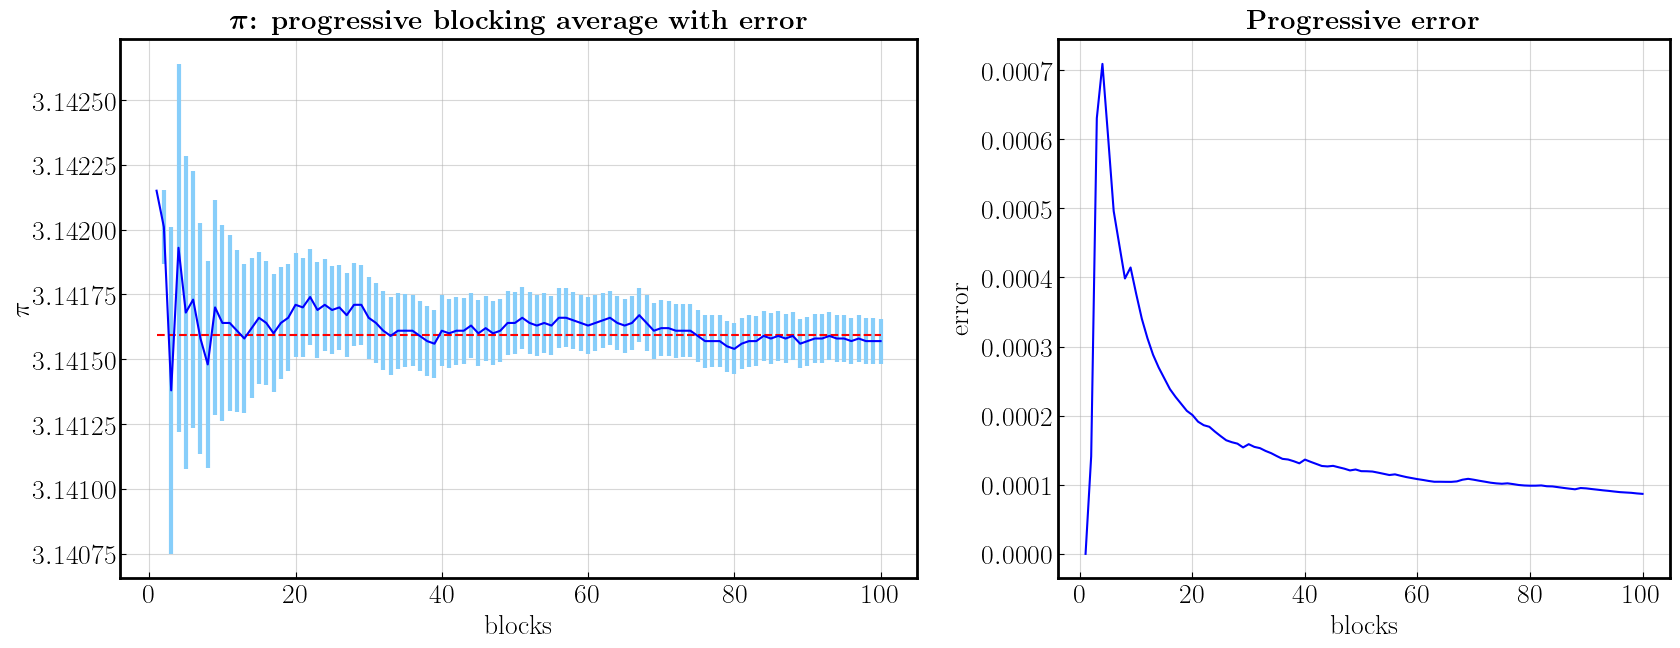

In [73]:
# plot pi value
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})


axs[0].errorbar(pi[:,0], pi[:,2], yerr=pi[:,3], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3)
p = np.ones(pi.shape[0])*np.pi
axs[0].plot(pi[:,0], p, linestyle='--', color='red')

axs[0].set_title(r'\textbf{\boldmath $\pi$: progressive blocking average with error}', pad=8)
axs[0].set_xlabel('blocks')
axs[0].set_ylabel(r'$\pi$', labelpad=-2)

axs[1].plot(pi[:,0], pi[:,3], color='blue')
axs[1].set_title(r'\textbf{Progressive error}', pad=8)
axs[1].set_xlabel('blocks')
axs[1].set_ylabel('error', labelpad=6)

plt.show()

This plots show the progressive value of the esteem of $\pi$ with its error and also the progressive value of the error itself. The obtained result is compatible within one $\sigma$ with $\pi$.

**Plot parameters**:
- Extractions: $10^9$
- Blocks: $10^2$
- Extractions in each block: $10^7$